In [146]:
# Import packages
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import statistics
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pycountry_convert as pc
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Import data
train = pd.read_csv("../01-data/train.csv", low_memory = False)
test = pd.read_csv("../01-data/test.csv", low_memory = False)

# Custom data
codebook = pd.read_csv("../01-data/codebook_compact.csv", low_memory = False) # OG codebook+dtypes from codebook_long

In [147]:
# Join train and test for processing - otherwise they end up with a different # of columns
train_labels = train['satisfied']
del train['satisfied']
train['data'] = 1
test['data'] = 0

all_data = train.append(test).reset_index(drop = True)

0.25% of the ages are missing.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.89% of the years are missing.
0.26% of the numbers are missing.
There are 67 features with over 30% missing.


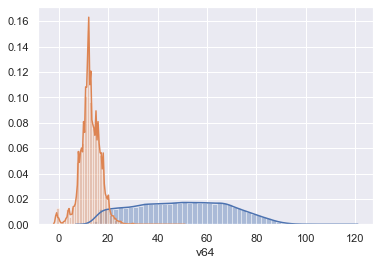

In [148]:
# Dealing with country vars on a case-by-case basis
cat_cols = ['v17', "v20", "v25", "v78", "v154", "v155", "v161", "cntry"]
cat_df = all_data[cat_cols]

## V17: Country of Birth

# Drop 99, 2, 4, 3, 77, 6
to_drop = ['99', '2', '4', '3', '77', '6', '88']
all_data['v17'] = all_data['v17'].replace(to_drop, "-1")
all_data['v17'] = all_data['v17'].replace('66', "0")

def convert_country(country):
    try:
        return(pc.country_alpha2_to_continent_code(country))
    except:
        return(country)

all_data['v17'] = all_data['v17'].apply(lambda x: convert_country(x))

# Only one observation is from TL, and none exist in the test set. Drop ID = 2441
all_data = all_data[all_data.v17 != 'TL']
all_data['v17'].value_counts()

all_data['v17'].isna().sum()

### Ignore b/c it is the #4 most important var in the lightgbm

## V20: Region 

# Country code + more specific region code. Convert to just country
# After stripping specific region code, only 6% of obs have a different entry here than for 'cntry'. Drop this column.
# all_data = all_data.drop('v20', axis = 1)

## V25: Citizenship

# Drop 65, 99, 6, convert rest to continents
to_drop = ['65', '99', '6', '88']
all_data['v25'] = all_data['v25'].replace(to_drop, '-1')
all_data['v25'] = all_data['v25'].replace('66', "0")
all_data['v25'] = all_data['v25'].apply(lambda x: convert_country(x))
all_data['v25'].value_counts()

all_data['v25'].isna().sum()

## V78: Country of birth, father AND V161: Country of birth, mother

# Drop errors, convert rest to continents
to_drop = ['99', '88', '2', '4', '3', '77', '6']
all_data['v78'] = all_data['v78'].replace(to_drop, '-1')
all_data['v78'] = all_data['v25'].replace('66', "0")
all_data['v78'] = all_data['v78'].apply(lambda x: convert_country(x))

all_data['v161'] = all_data['v161'].replace(to_drop, '-1')
all_data['v161'] = all_data['v161'].replace('66', "0")
all_data['v161'] = all_data['v161'].apply(lambda x: convert_country(x))

all_data['v78'].isna().sum()

all_data['v161'].isna().sum()

## V154: Language most often spoken at home: first mentioned

# Drop errors
to_drop = ['999','888','777']
all_data['v154'] = all_data['v154'].replace(to_drop, '-1')

# Leaving ENG and GER as is 
missing = ["."]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO"]
bal = ["CZE", "LIT"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE"]
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON"]

languages = {language: 'EUR' for language in eur}
languages.update({language: '-1' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

all_data['v154'] = all_data['v154'].map(languages)

all_data['v154'].value_counts(normalize = True)

all_data['v154'] = all_data['v154'].fillna(-1).astype(str)

all_data['v154'].isna().sum()

## V155: Language most often spoken at home: second mentioned

# Assuming 0 means no other language, and 999, 888, 777 are missing
to_drop = ['999','888','777']
all_data['v155'] = all_data['v155'].replace(to_drop, '-1')

## Check if any weren't present in the previous question
lang_v154 = ["GER","ENG","FRE","CZE","LIT","FIN","POL","DUT","SWE","HEB","SPA",
             "HUN","DAN","NOR","POR","EST","SLV","RUS","GSW","ARA","CAT","TUR",
             "ITA","GLG","SRP","BOS","ALB","FRS","RUM","KUR","HRV","BAQ","URD",
             "PER","AMH","APA","ROA","CHI","HIN","ARM","GLE","SOM","SLO","IRA",
             "TAM","GEM","GUJ","ROM","CPP","FRM","GRE","WEL","VIE","BUL","UKR",
             "YID","BER","PAP","MIS","BEN","SLA","LAV","MAL","THA","TGL","NEP",
             "MAY","SYR","AZE","UZB","PAN","TGK","MLG","ROH","TIR","MAN","TAI",
             "LIN","KAB","EGY","BEL","WOL","BAM","TIB","AKA","SWA","IND","SUX",
             "TEL","FAO","JPN","SRN","SUS","ICE","SNK","FIL","ABK","GEO","TIG",
             "NAP","AST","FRO","LAO","CPF","MON","MDR"]

lang_v155 = all_data['v155'].unique().tolist()

new_languages = [language for language in lang_v155 if language not in lang_v154]

# New language dict: leaving ENG and GER as is 
none = ['0']
missing = ["-1"]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO","ENM","OCI","BRE",
       "NDS","WLN","VOL","MWL"]
bal = ["CZE", "LIT", "MAC", "CSB"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG",
       "EWE","RUN","IBO","YOR","FON","KON","DYU","KIN","NIC","NDE","HER","KIK"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE", 'SMN']
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF", "MAR"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON","ZXX","TPI","GRN","SGN","HUP","NAH","HAT","CAD","PHI","MAO"]

 
languages = {language: 'EUR' for language in eur}
languages.update({language: '0' for language in none})
languages.update({language: '-1' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

# Map langauges to their groups
all_data['v155'] = all_data['v155'].map(languages)

all_data['v155'].value_counts(normalize = True)

all_data['v155'].isna().sum()

all_data['cntry'].isna().sum()

## V3: Age of respondent, calculated

missing_age = round(len(all_data[all_data['v3'] == '.a'])/len(all_data) * 100, 2)
print(str(missing_age) + "% of the ages are missing.")

# Using EDA notebook, the highest positive and negatively linearly correlated vars with Age (v3):
# Positive: v217, v163, v218, v103, v99
# Negative: v54, v196, v208, v100, v159	
cols = ['v3','v217','v218', 'v54']

regress_age = all_data[cols]
train_lr = regress_age[regress_age['v3'] != '.a']
test_lr = regress_age[regress_age['v3'] == '.a']

for col in cols:
    train_lr[col] = pd.to_numeric(all_data[col], errors = 'coerce')

# Drop all na
train_lr = train_lr.dropna()

X_train = train_lr.loc[:, train_lr.columns != 'v3']
y_train = train_lr['v3']

# Linear regression
regressor = lgb.LGBMRegressor()  
regressor.fit(X_train, y_train) 

del test_lr['v3']
test_lr = test_lr.replace(['.a', '.b', '.c', '.d'], np.nan).dropna()

test_lr["predicted_age"] = regressor.predict(test_lr)

# Gives R2 score of 0.63 but better than imputation by mean
# metrics.r2_score(label, train_no_na["predicted_age"])

# Filling in missing values with predicted age
index_predicted = test_lr.drop(['v217','v218', 'v54'], axis = 1).index
index_missing = all_data[all_data['v3'] == '.a'].index

all_data = all_data.join(test_lr['predicted_age'])
all_data['v3_imputed'] = np.where(all_data['v3'] == '.a', all_data['predicted_age'], all_data['v3']).astype("float64")
# Delete other versions of age
del all_data['v3']
del all_data['predicted_age']

# Plot age distribution
sns.set(color_codes=True)
sns.distplot(all_data['v3_imputed'].astype("float64"));

# (37.0, 44.0]
# (23.0, 31.0]
# (44.0, 50.0]
# (61.0, 67.0]
# (55.0, 61.0]
# (13.999, 23.0]
# (74.423, 114.0]
# (67.0, 74.423]
# (31.0, 37.0]
# (50.0, 55.0]

bin_labels = [1,2,3,4,5,6,7,8,9,10]
all_data['v3_binned'] = pd.qcut(all_data['v3_imputed'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

del all_data['v3_imputed']

# Drop v102 as it is almost the same as v103 but with less information
del all_data['v102']

# Drop v57, v59, v61, v63 as v56, v58, v60, v62 gives the same information but mapped to categories
del all_data['v57']
del all_data['v59']
del all_data['v61']
del all_data['v63']

# V64: Years of full time education completed

# Combine all missing
all_data['v64'] = pd.to_numeric(all_data['v64'], errors='coerce')

missing_age = round(len(all_data[all_data['v64'].isnull()])/len(all_data) * 100, 2)
print(str(missing_age) + "% of the years are missing.")

# Plot distribution
sns.distplot(all_data['v64'].fillna(-1));



# Fill with mean bc I'm tired
all_data['v64'] = pd.to_numeric(all_data['v64'], errors = 'coerce')
mean_years = np.nanmean(all_data['v64'])
all_data['v64'] = all_data['v64'].fillna(mean_years)

## Now bin education
all_data['v64'].describe()

bin_labels = [1,2,3,4,5]
all_data['v64_binned'] = pd.qcut(all_data['v64'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

all_data['v64_binned'].value_counts()
del all_data['v64']

## V100: Number of people living regularly as member of household
# Group everything more than 6 into "6+", i.e. 6

# Combine all missing
all_data['v100'] = pd.to_numeric(all_data['v100'], errors='coerce')

missing_age = round(len(all_data[all_data['v100'].isnull()])/len(all_data) * 100, 2)
print(str(missing_age) + "% of the numbers are missing.")

# Fill with mean
mean_years = np.nanmean(all_data['v100'])
all_data['v100'] = all_data['v100'].fillna(mean_years).astype("int64")

# Grouping large values
all_data['v100_grouped'] = np.where(all_data['v100'] > 6, 6, all_data['v100']).astype("int64")
all_data['v100_grouped'].value_counts()

# v128: End of interview, month
# v129: Start of interview, month
# End and start of interview are only not equal for 0.18% of observations
# We keep v129 since there are no missing
del all_data['v128']

# Define: 3-5 = Spring, 6-8 = Summer, 9-11 = Autumn, 12-2 = Winter - in Germany
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]

# Dictionary for seasons
seasons = {season: 'WI' for season in winter}
seasons.update({season: 'SP' for season in spring})
seasons.update({season: 'SU' for season in summer})
seasons.update({season: 'AU' for season in autumn})

# Map langauges to their groups
all_data['start_interview_season'] = all_data['v129'].map(seasons)
all_data['start_interview_season'].value_counts(normalize = True)

# Delete original variable
del all_data['v129']

# v126: end of interview, hour
# v130: start of interview, hour

# Impute with mean
all_data['v126'] = pd.to_numeric(all_data['v126'], errors='coerce')
all_data['v126'] = all_data['v126'].fillna(np.nanmean(all_data['v126'])).astype('int64')
all_data['v130'] = pd.to_numeric(all_data['v130'], errors='coerce')
all_data['v130'] = all_data['v130'].fillna(np.nanmean(all_data['v130'])).astype('int64')

bin_labels = [1,2,3,4,5]
all_data['v126_binned'] = pd.qcut(all_data['v126'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)
all_data['v130_binned'] = pd.qcut(all_data['v130'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

# Delete original variables
del all_data['v126']
del all_data['v130']

# v132: Interview length in minutes - bin in quantiles
bin_labels = [1,2,3,4,5,6,7,8,9,10]
all_data['v132_binned'] = pd.qcut(all_data['v132'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

# Delete original variable
del all_data['v132']

# v250: Total contracted hours per week in main job OT excluded
all_data['v250'] = pd.to_numeric(all_data['v250'], errors = 'coerce')
all_data['v250_binned'] = pd.cut(all_data['v250'], 4, labels=[1,2,3,4])

del all_data['v250']

# v251: Total hours normally worked per week main job OT included
all_data['v251'] = pd.to_numeric(all_data['v251'], errors = 'coerce')
all_data['v251_binned'] = pd.cut(all_data['v251'], 4, labels=[1,2,3,4])

del all_data['v251']

# v251: Total hours normally worked per week main job OT included - partner
all_data['v252'] = pd.to_numeric(all_data['v252'], errors = 'coerce')
all_data['v252_binned'] = pd.cut(all_data['v252'], 4, labels=[1,2,3,4])

del all_data['v252']

all_data['v252_binned'].value_counts()

# v168: Number of people responsible for in job

all_data['v168'] = pd.to_numeric(all_data['v168'], errors = 'coerce')
all_data['v168'] = all_data['v168'].fillna(0).astype('int64')

# Define:
none = [0]
few = [1,2,3,4,5,6,7,8,9,10]
moderate = [11,12,13,14,15,16,17,18,19,20]
many = range(21, max(all_data['v168']))

# Dictionary for seasons
people = {people: 0 for people in none}
people.update({people: 1 for people in few})
people.update({people: 2 for people in moderate})
people.update({people: 3 for people in many})

# Map langauges to their groups
all_data['manage'] = all_data['v168'].map(people)
all_data['manage'].value_counts(normalize = True)

# Delete original variable
del all_data['v168']

all_data['v153'] = pd.to_numeric(all_data['v153'], errors = 'coerce')
all_data['v153'] = all_data['v153'].fillna(0).astype('int64')

# Define:
na = [0]
before_80 = range(1, 1980)
after_80 = range(1981, max(all_data['v153']))

# Dictionary for seasons
immigrate = {immigrate: 0 for immigrate in na}
immigrate.update({immigrate: 1 for immigrate in before_80})
immigrate.update({immigrate: 2 for immigrate in after_80})

# Map langauges to their groups
all_data['immigrate'] = all_data['v153'].map(immigrate)
all_data['immigrate'].value_counts(normalize = True)

# Delete original variable
del all_data['v153']

all_data['single'] = np.where(all_data['v164'] == '.a', 1, 0)

dots = ['.a', '.b', '.c', '.d']
all_data['employees'] = np.where(np.isin(all_data['v69'], dots) , 0, 1)

# Convert binned vars to int to fillna
binned = ["v3_binned","v64_binned", "v126_binned", "v130_binned", "v132_binned", 
          "v250_binned", "v251_binned", "v252_binned"]

for col in binned:
    all_data[col] = all_data[col].astype('int64')

all_data = all_data.fillna(".")

# # convert cat vars to dtype 'categorical'
# all_data[cat_cols] = all_data[cat_cols].astype('category')
# all_data.dtypes

# Treating missing 
all_data_copy = all_data.copy()
all_data_nodots = all_data_copy.replace([".", ".a", ".b", ".c", ".d"], [np.nan, np.nan, np.nan, np.nan, np.nan])
percent_missing_nodots = all_data_nodots.isnull().sum() * 100 / len(all_data_nodots)
missing_value_df_nodots = pd.DataFrame({'column_name': all_data_nodots.columns,
                                 'percent_missing': percent_missing_nodots})

# Columns where % missing > some percent
percent = 30
cols_missing = missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent]
n_cols_missing = len(missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent])
print("There are " + str(n_cols_missing) + " features with over " + str(percent) + "% missing.")

# Attach short desc for more context
codebook_labels = ['Variable', "Label"]
missing = cols_missing.merge(codebook[codebook_labels], left_on = 'column_name', right_on = "Variable", how = "left")
missing.sort_values(by = "percent_missing", ascending = False)

# Drop - these vars are above 90.6% missing, or 3+ 
drop_missing = ['v22','v23','v69','v86','v87','v88','v89','v91','v92','v93','v94','v95','v96','v97',
                'v123','v164','v174','v191','v192','v193','v194','v195','v197','v198','v199','v200',
                'v201','v202','v203','v204','v205','v206','v207','v209','v210','v211','v212','v213',
                'v214','v215','v259','v260','v261','v262','v264','v265','v266','v267','v268','v269',
                'v270',]
# all_data_dropped = all_data_nodots.drop(drop_missing, axis = 1)
all_data_dropped = all_data.drop(drop_missing, axis = 1)

# Impute the rest
# dots = [".", ".a", ".b", ".c", ".d", np.nan]
# all_data_imputed = all_data_dropped.replace(dots, [-1, -1, -1, -1, -1, -1])

all_data_dropped['v158'].value_counts()

all_data_dropped['v158'].isnull().sum()

# v158 : Main activity last 7 days - bin into working, not working, other
to_drop = ['.a','.d','b','.c']
all_data_dropped['v158'] = all_data_dropped['v158'].replace(to_drop, 9)

all_data_dropped['v158'] = pd.to_numeric(all_data_dropped['v158'], errors = 'coerce')
all_data_dropped['v158'] = all_data_dropped['v158'].fillna(0).astype('int64')

# Define:
paid_work = [1]
unpaid_work = [8,2,7]
not_working = [6,5,3,4]
other = [9]

# Dictionary for activity
activity = {activity: 0 for activity in other}
activity.update({activity: 1 for activity in paid_work})
activity.update({activity: 2 for activity in unpaid_work})
activity.update({activity: 3 for activity in not_working})

# Map langauges to their groups
all_data_dropped['main_activity'] = all_data_dropped['v158'].map(activity)
all_data_dropped['main_activity'].value_counts(normalize = True)

# Delete original variable
del all_data_dropped['v158']

# v241 : Any period of unemployment and work seeking lasted 12 months or more
all_data_dropped['v241'] = all_data_dropped['v241'].replace('.a', 0)
all_data_dropped['v241'] = all_data_dropped['v241'].replace(['.b','.c','.d'], -1)
all_data_dropped['v241'] = pd.to_numeric(all_data_dropped['v241'], errors = 'coerce')
all_data_dropped['v241'] = all_data_dropped['v241'].fillna(-1).astype('int64')
all_data_dropped['v241'].value_counts()

# v243 : Any period of unemployment and work seeking lasted 5 years or more
all_data_dropped['v243'] = all_data_dropped['v243'].replace('.a', 0)
all_data_dropped['v243'] = all_data_dropped['v243'].replace(['.b','.c','.d'], -1)
all_data_dropped['v243'] = pd.to_numeric(all_data_dropped['v243'], errors = 'coerce')
all_data_dropped['v243'] = all_data_dropped['v243'].fillna(-1).astype('int64')
all_data_dropped['v243'].value_counts()

# v5 : Second ancestry, European Standard Classification of Cultural and Ethnic Groups
all_data_dropped['v5'] = all_data_dropped['v5'].replace('.a', 0)
all_data_dropped['v5'] = all_data_dropped['v5'].replace(['.b','.c','.d'], -1)
all_data_dropped['v5'] = pd.to_numeric(all_data_dropped['v5'], errors = 'coerce')
all_data_dropped['v5'] = all_data_dropped['v5'].fillna(-1).astype('int64')
all_data_dropped['v5'].value_counts()

# v151 : Occupation partner, ISCO08
all_data_dropped['v151'] = all_data_dropped['v151'].replace('.a', 0)
all_data_dropped['v151'] = all_data_dropped['v151'].replace(['.b','.c','.d'], -1)
all_data_dropped['v151'] = pd.to_numeric(all_data_dropped['v151'], errors = 'coerce')
all_data_dropped['v151'] = all_data_dropped['v151'].fillna(-1).astype('int64')
all_data_dropped['v151'].value_counts()

# v71 : Partner's employment relation
all_data_dropped['v71'] = all_data_dropped['v71'].replace('.a', 0)
all_data_dropped['v71'] = all_data_dropped['v71'].replace(['.b','.c','.d'], -1)
all_data_dropped['v71'] = pd.to_numeric(all_data_dropped['v71'], errors = 'coerce')
all_data_dropped['v71'] = all_data_dropped['v71'].fillna(-1).astype('int64')
all_data_dropped['v71'].value_counts()

# v188 : Ever belonging to particular religion or denomination
all_data_dropped['v188'] = all_data_dropped['v188'].replace('.a', 0)
all_data_dropped['v188'] = all_data_dropped['v188'].replace(['.b','.c','.d'], -1)
all_data_dropped['v188'] = pd.to_numeric(all_data_dropped['v188'], errors = 'coerce')
all_data_dropped['v188'] = all_data_dropped['v188'].fillna(-1).astype('int64')
all_data_dropped['v188'].value_counts()

# v173 : Ever had a paid job
all_data_dropped['v173'] = all_data_dropped['v173'].replace('.a', 0)
all_data_dropped['v173'] = all_data_dropped['v173'].replace(['.b','.c','.d'], -1)
all_data_dropped['v173'] = pd.to_numeric(all_data_dropped['v173'], errors = 'coerce')
all_data_dropped['v173'] = all_data_dropped['v173'].fillna(-1).astype('int64')
all_data_dropped['v173'].value_counts()

# v182 : How close to party
all_data_dropped['v182'] = all_data_dropped['v182'].replace('.a', 0)
all_data_dropped['v182'] = all_data_dropped['v182'].replace(['.b','.c','.d'], -1)
all_data_dropped['v182'] = pd.to_numeric(all_data_dropped['v182'], errors = 'coerce')
all_data_dropped['v182'] = all_data_dropped['v182'].fillna(-1).astype('int64')
all_data_dropped['v182'].value_counts()

# v160 : Legal marital status
all_data_dropped['v160'] = all_data_dropped['v160'].replace('.a', 0)
all_data_dropped['v160'] = all_data_dropped['v160'].replace(['.b','.c','.d'], -1)
all_data_dropped['v160'] = pd.to_numeric(all_data_dropped['v160'], errors = 'coerce')
all_data_dropped['v160'] = all_data_dropped['v160'].fillna(-1).astype('int64')
all_data_dropped['v160'].value_counts()

# v62 : Partner's highest level of education
all_data_dropped['v62'] = all_data_dropped['v62'].replace('.a', 0)
all_data_dropped['v62'] = all_data_dropped['v62'].replace(['.b','.c','.d'], -1)
all_data_dropped['v62'] = pd.to_numeric(all_data_dropped['v62'], errors = 'coerce')
all_data_dropped['v62'] = all_data_dropped['v62'].fillna(-1).astype('int64')
all_data_dropped['v62'].value_counts()

# v68 : Partner's highest level of education, ES - ISCED
all_data_dropped['v68'] = all_data_dropped['v68'].replace('.a', 0)
all_data_dropped['v68'] = all_data_dropped['v68'].replace(['.b','.c','.d'], -1)
all_data_dropped['v68'] = pd.to_numeric(all_data_dropped['v68'], errors = 'coerce')
all_data_dropped['v68'] = all_data_dropped['v68'].fillna(-1).astype('int64')
all_data_dropped['v68'].value_counts()

# v190 : Religion or denomination belonging to at present
all_data_dropped['v190'] = all_data_dropped['v190'].replace('.a', 0)
all_data_dropped['v190'] = all_data_dropped['v190'].replace(['.b','.c','.d'], -1)
all_data_dropped['v190'] = pd.to_numeric(all_data_dropped['v190'], errors = 'coerce')
all_data_dropped['v190'] = all_data_dropped['v190'].fillna(-1).astype('int64')
all_data_dropped['v190'].value_counts()

# v170 : Mother's occupation when respondent 14
all_data_dropped['v170'] = all_data_dropped['v170'].replace('.a', 0)
all_data_dropped['v170'] = all_data_dropped['v170'].replace(['.b','.c','.d'], -1)
all_data_dropped['v170'] = pd.to_numeric(all_data_dropped['v170'], errors = 'coerce')
all_data_dropped['v170'] = all_data_dropped['v170'].fillna(-1).astype('int64')
all_data_dropped['v170'].value_counts()

# v216 : Relationship with husband/wife/partner currently living with
all_data_dropped['v216'] = all_data_dropped['v216'].replace('.a', 0)
all_data_dropped['v216'] = all_data_dropped['v216'].replace(['.b','.c','.d'], -1)
all_data_dropped['v216'] = pd.to_numeric(all_data_dropped['v216'], errors = 'coerce')
all_data_dropped['v216'] = all_data_dropped['v216'].fillna(-1).astype('int64')
all_data_dropped['v216'].value_counts()

# v11 : Ever had children living in household
all_data_dropped['v11'] = all_data_dropped['v11'].replace('.a', 0)
all_data_dropped['v11'] = all_data_dropped['v11'].replace(['.b','.c','.d'], -1)
all_data_dropped['v11'] = pd.to_numeric(all_data_dropped['v11'], errors = 'coerce')
all_data_dropped['v11'] = all_data_dropped['v11'].fillna(-1).astype('int64')
all_data_dropped['v11'].value_counts()

# quick fix
all_data_dropped['v252_binned'] = np.where(all_data_dropped['v252_binned'] < 1, 0, all_data_dropped['v252_binned'])
all_data_dropped['v251_binned'] = np.where(all_data_dropped['v251_binned'] < 1, 0, all_data_dropped['v251_binned'])
all_data_dropped['v250_binned'] = np.where(all_data_dropped['v250_binned'] < 1, 0, all_data_dropped['v250_binned'])

# All others
all_data_encoded = all_data_dropped.replace(".b", -1)
all_data_encoded = all_data_dropped.replace(".a", -1)
all_data_encoded = all_data_dropped.replace(".c", -1)
all_data_encoded = all_data_dropped.replace(".d", -1)
all_data_encoded = all_data_dropped.replace(".", -1)

# These can be any type 
binary = ['v6','v7','v8','v9','v10','v11','v12','v14','v15','v16','v18', 'v21','v24','v26','v27',
         'v28','v29','v30','v31','v32','v33','v34','v36','v37','v38','v39','v40','v41','v42','v43','v44','v45',
         'v46','v47','v48','v49','v50','v51','v52','v53','v54','v55','v77','v85','v90',
         'v106','v107','v108','v152','v157','v162','v165','v166','v171','v172','v173','v175','v176','v187',
         'v188','v217','v218','v221','v241','v242','v243','v244','v245','v246','v247','v254','v256','v257']

# These can be any type - we one-hot or label encode these
nominal = ['v4','v5','v20','v70','v71','v72','v73','v103','v150',
          'v151','v159','v160','v163','v167','v169','v170','v190',
          'v196','v208','v216','v231','v248','v255','cntry']

# Should be numeric
numeric = ['v100','v124','v125','v127','v131','v134',
           'v228','v229','v230','v133']

# Has an order - set as categorical and apply order
ordinal = ['v1','v2','v13','v19', 'v35','v56','v58','v60','v62','v65','v66','v67','v68','v74','v75','v79',
          'v80','v81','v82','v83','v84','v99','v101','v104','v105','v110','v111','v112','v113','v114','v115',
          'v116','v117','v118','v119','v122','v135','v136','v137','v138','v139','v140','v141','v142','v143',
          'v144','v145','v146','v147','v148','v149','v177','v181','v182','v185','v186','v219','v220',
          'v222','v223','v224','v225','v226','v227','v232','v233','v234','v235','v236','v237','v238','v239',
          'v240','v249','v253','v258','v263','v76','v98','v109','v120','v121','v156',
          'v178','v179','v180','v184','v189','v183']

In [149]:
all_data_encoded[binary] = all_data_encoded[binary].replace('.a', -1)
all_data_encoded[binary] = all_data_encoded[binary].replace(['.b', '.c', '.d'], -2)

In [150]:
# Impute all rest NA in ordinal with mean
for col in ordinal:
    all_data_encoded[col] = pd.to_numeric(all_data_encoded[col], errors = "coerce")
    colmean = np.nanmean(all_data_encoded[col])
    all_data_encoded[col] = all_data_encoded[col].fillna(round(colmean))

In [151]:
one_hot = ['v17','v25','v78','v161', 'v154', 'v155', 'start_interview_season']
all_data_encoded = pd.get_dummies(all_data_encoded, prefix=one_hot, columns=one_hot)

In [152]:
# Label encode 
for col in nominal:
    label_encoder = preprocessing.LabelEncoder()
    all_data_encoded[col] = label_encoder.fit_transform(all_data_encoded[col])

In [153]:
all_data_encoded[binary] = all_data_encoded[binary].astype("category")
all_data_encoded[nominal] = all_data_encoded[nominal].astype("category")

In [154]:
# Convert to category, preserving order
cat_type = CategoricalDtype(categories=range(0,3000),ordered=True)
all_data_encoded[ordinal] = all_data_encoded[ordinal].astype("int64")
all_data_encoded[ordinal] = all_data_encoded[ordinal].astype(cat_type)

In [155]:
#### Numeric - Just treat NA

# Impute rest of the NA with mean
for col in numeric:
    all_data_encoded[col] = pd.to_numeric(all_data_encoded[col], errors = "coerce")
    colmean = np.nanmean(all_data_encoded[col])
    all_data_encoded[col] = all_data_encoded[col].fillna(colmean)
    
all_data_encoded[numeric] = all_data_encoded[numeric].astype("int64")

In [164]:
test = all_data_encoded[all_data_encoded['data']==0]
train = all_data_encoded[all_data_encoded['data']==1]
train['satisfied'] = train_labels

del test['data']
del train['data']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train.to_csv("train_FE_Final.csv")
test.to_csv("test_FE_Final.csv")